In [3]:
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df = pd.read_csv('/content/sample_data/formspring_data.csv',delimiter='\t',quoting=3)

In [10]:
df = df[['ques','ans1']]  #limiting to question and answer 
#replacing html symbols
df['ques'] = df['ques'].str.replace('&#039;',' ')
df['ques'] = df['ques'].str.replace('&quot;',' ')
df['ques'] = df['ques'].str.replace('<br>',' ')    

In [11]:
df = df.dropna()
positives = df[df['ans1']=='Yes']
negatives = df[df['ans1']=='No']
frames = [positives,negatives]

In [12]:
df = pd.concat(frames)
df = df.sample(frac=1)

In [13]:
df['ans1'] = df['ans1'].replace(('Yes','No'),(1,0))
bag = []
def clean_data(sentence):
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = sentence.lower().split()
    words = [word for word in sentence if not word in stopwords.words('english')]
    sentence = ' '.join(words)
    bag.append(sentence)

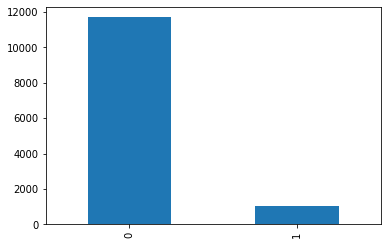

In [14]:
df['ans1'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [15]:
df['ans1'].value_counts()

0    11691
1     1038
Name: ans1, dtype: int64

In [17]:
import re
df['ques'].apply(clean_data)

3675     None
2431     None
9601     None
5887     None
12482    None
         ... 
1410     None
2596     None
6        None
5694     None
2162     None
Name: ques, Length: 12729, dtype: object

In [18]:
tokenizer = Tokenizer(num_words=20000)

In [19]:
X = df['ques'].values
tokenizer.fit_on_texts(X)
print(tokenizer.word_index)

{'you': 1, 'i': 2, 'a': 3, 'the': 4, 'to': 5, 'do': 6, 'what': 7, 'your': 8, 'is': 9, 'and': 10, 'it': 11, 'have': 12, 'in': 13, 'of': 14, 'u': 15, 'or': 16, 'are': 17, 'if': 18, 'would': 19, 'that': 20, 'like': 21, 'on': 22, 'me': 23, 'how': 24, 'be': 25, 'for': 26, 's': 27, 'ever': 28, 'my': 29, 'apos': 30, 'so': 31, 'why': 32, 'with': 33, 'who': 34, 'was': 35, 'think': 36, 'not': 37, 'r': 38, 'know': 39, 'lol': 40, 'when': 41, 't': 42, 'd': 43, 'love': 44, 'can': 45, 'one': 46, 'just': 47, 'about': 48, 'get': 49, 'but': 50, 'did': 51, 'up': 52, 'at': 53, '3': 54, 'people': 55, 'this': 56, 'im': 57, 'they': 58, 'go': 59, 'out': 60, 'ur': 61, 'all': 62, 'want': 63, 'were': 64, 'm': 65, 'there': 66, 'time': 67, 'someone': 68, 'now': 69, 'favorite': 70, 'haha': 71, 'had': 72, 'no': 73, 'from': 74, 'any': 75, 'as': 76, 'could': 77, 'p': 78, 'them': 79, 'last': 80, '39': 81, 'most': 82, 'say': 83, 'we': 84, 'been': 85, 'life': 86, 'person': 87, 're': 88, 'thing': 89, 'an': 90, 'really': 9

In [20]:
len(tokenizer.word_index)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X,maxlen=250)

In [21]:
y = df['ans1'].values.astype(int)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [23]:
model = Sequential()
model.add(Embedding(20000,120))
model.add(LSTM(120,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])


In [33]:
history = model.fit(X_train,y_train,batch_size=45,epochs=3,verbose=2,validation_data=(X_test,y_test))

Epoch 1/3
213/213 - 165s - loss: 0.0666 - accuracy: 0.9774 - f1_m: 0.8351 - precision_m: 0.8967 - recall_m: 0.8235 - val_loss: 0.3487 - val_accuracy: 0.8982 - val_f1_m: 0.3003 - val_precision_m: 0.3496 - val_recall_m: 0.3083
Epoch 2/3
213/213 - 164s - loss: 0.0503 - accuracy: 0.9839 - f1_m: 0.8656 - precision_m: 0.9074 - recall_m: 0.8558 - val_loss: 0.3830 - val_accuracy: 0.8882 - val_f1_m: 0.3183 - val_precision_m: 0.3326 - val_recall_m: 0.3497
Epoch 3/3
213/213 - 165s - loss: 0.0383 - accuracy: 0.9869 - f1_m: 0.8875 - precision_m: 0.9260 - recall_m: 0.8742 - val_loss: 0.4814 - val_accuracy: 0.8665 - val_f1_m: 0.3248 - val_precision_m: 0.2900 - val_recall_m: 0.4242


In [34]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test,batch_size=45,verbose=2)

71/71 - 6s - loss: 0.4814 - accuracy: 0.8665 - f1_m: 0.3248 - precision_m: 0.2900 - recall_m: 0.4242


In [35]:
test_sentence = ['You are a stupid bitch']

In [36]:
def pre(sentence):
  seq = tokenizer.texts_to_sequences(sentence)
  padded_seq = sequence.pad_sequences(seq,maxlen=250)
  pred = model.predict(padded_seq)
  pred_actual = round(pred[0][0],2)
  result = "This sentence has a "+str(pred_actual)+" probability of containing cyberbullying content"
  print( result)

In [37]:
pre(test_sentence)

This sentence has a 0.99 probability of containing cyberbullying content


In [38]:
pre(['You are a terrible liar'])

This sentence has a 0.29 probability of containing cyberbullying content


In [39]:
pre(['Why are you stupid?'])

This sentence has a 0.95 probability of containing cyberbullying content


In [40]:
pre(['Hello How are you doing?'])

This sentence has a 0.03 probability of containing cyberbullying content


In [41]:
pre(['I"m going to kill you and your family'])

This sentence has a 0.17 probability of containing cyberbullying content


In [42]:
pre(['You are a punkass'])

This sentence has a 0.49 probability of containing cyberbullying content


In [43]:
pre(['you are a fucked up bitch !'])

This sentence has a 1.0 probability of containing cyberbullying content


In [44]:
from sklearn.metrics import roc_curve


In [53]:
y_pred = model.predict(X_test).ravel()

In [54]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

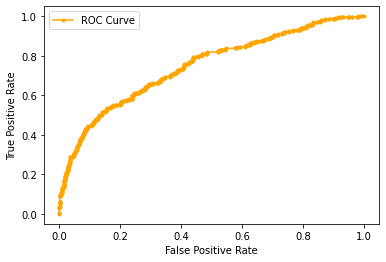

In [56]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()